[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/usermarat/Flight_delays_project/blob/main/model_usage_app.ipynb)

# Установка и загрузка библиотек

In [1]:
! pip install geopandas
! pip install catboost

In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import geopandas as gpd

import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostRegressor

import ipywidgets as wg
from IPython.display import display
import datetime

# Применение модели в прототипе приложения

## Подгрузка датасетов и модели

In [5]:
! gdown 1-1MlIE4pO2Yv8L2YBlL-HdpIIUpCjSdM # flights final features
! gdown 1--8k6P3L5dWVdWb6AUJXx2OxDgCefs1h # airports
! gdown 1yrbKRAQXp-cbRQqalJ0GZfFLSboS4Ol8 # airlines
! gdown 1W2lpJxIt117zdQX6azqWdkrtw2cCyLNs # flights network
! gdown 1Jk5_MibC0kM-L7VAV4emFDg9m6XG3bIF # model weights

Downloading...
From: https://drive.google.com/uc?id=1-1MlIE4pO2Yv8L2YBlL-HdpIIUpCjSdM
To: /content/flights_final.csv
100% 2.28G/2.28G [00:22<00:00, 102MB/s]
Downloading...
From: https://drive.google.com/uc?id=1--8k6P3L5dWVdWb6AUJXx2OxDgCefs1h
To: /content/airports_new.csv
100% 26.5k/26.5k [00:00<00:00, 74.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1yrbKRAQXp-cbRQqalJ0GZfFLSboS4Ol8
To: /content/airlines.csv
100% 359/359 [00:00<00:00, 1.72MB/s]
Downloading...
From: https://drive.google.com/uc?id=1W2lpJxIt117zdQX6azqWdkrtw2cCyLNs
To: /content/airport_net.gml
100% 294k/294k [00:00<00:00, 3.62MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Jk5_MibC0kM-L7VAV4emFDg9m6XG3bIF
To: /content/model.cbm
100% 20.8M/20.8M [00:00<00:00, 71.1MB/s]


In [4]:
flights = pd.read_csv('./flights_final.csv')
airports = pd.read_csv('./airports_new.csv')
airlines = pd.read_csv('./airlines.csv')
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
G = nx.read_gml('./airport_net.gml')
cb_reg = CatBoostRegressor()
cb_reg.load_model('./model.cbm')

<ipython-input-4-6c0e28ed79c9>:4: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))


## Задание функции (порядок работы указан ниже)

In [30]:
def delay_predict(aip_out, year, month, day, hour, aip_in=None, airline=None, minute=None):
    if aip_in is None:
        df = flights.query('ORIGIN_AIRPORT == @aip_out')
        df_agg = df.groupby('DESTINATION_AIRPORT',
                            as_index=False).agg({
                                            'HOUR': lambda x: hour,
                                            'MINUTE': lambda x: minute if minute is not None else 0,
                                            'TAXI_OUT': 'median',
                                            'TAXI_IN': 'median',
                                            'SCHEDULED_TIME': 'median',
                                            'DISTANCE': lambda x: x.value_counts().index[0],
                                            'LATITUDE_ORIG': lambda x: x.value_counts().index[0],
                                            'LONGITUDE_ORIG': lambda x: x.value_counts().index[0],
                                            'LATITUDE_DEST': lambda x: x.value_counts().index[0],
                                            'LONGITUDE_DEST': lambda x: x.value_counts().index[0],
                                            'ORIGIN_AIRPORT_DEG': lambda x: x.value_counts().index[0],
                                            'ORIGIN_AIRPORT_CLS': lambda x: x.value_counts().index[0],
                                            'ORIGIN_AIRPORT_BTW': lambda x: x.value_counts().index[0],
                                            'DESTINATION_AIRPORT_DEG': lambda x: x.value_counts().index[0],
                                            'DESTINATION_AIRPORT_CLS': lambda x: x.value_counts().index[0],
                                            'DESTINATION_AIRPORT_BTW': lambda x: x.value_counts().index[0],
                                            'EDGE_BTW': lambda x: x.value_counts().index[0],
                                            'MONTH': lambda x: month,
                                            'DAY': lambda x: day,
                                            'AIRLINE': lambda x: airline if airline is not None else x.value_counts().index[0]
                                            })

        df_agg['DAY_OF_WEEK'] = datetime.date(year, month, day).weekday() + 1
        df_agg['WEEKEND'] = np.where((df_agg['DAY_OF_WEEK'].values == 6) | (df_agg['DAY_OF_WEEK'].values == 7), 1, 0)
        df_agg['pred_DEL'] = cb_reg.predict(df_agg[cb_reg.feature_names_])
        res = df_agg.sort_values('pred_DEL').iloc[:3].merge(airports,
                                                            left_on='DESTINATION_AIRPORT',
                                                            right_on='IATA_CODE')[['DESTINATION_AIRPORT','AIRPORT',
                                                                                    'CITY', 'STATE', 'pred_DEL']]
        fig, ax = plt.subplots(figsize=(10,8))
        countries.query('name == "United States of America"').plot(color="lightgrey", ax=ax)
        pos = nx.get_node_attributes(G, 'location')
        nx.draw_networkx_nodes(G, pos, [aip_out, *res.DESTINATION_AIRPORT.values], node_size=100, alpha=0.6, label=True, ax=ax)
        nx.draw_networkx_labels(G, pos, labels={v: v for v in [aip_out, *res.DESTINATION_AIRPORT.values]}, alpha=0.8, font_size=10)
        nx.draw_networkx_edges(G, pos, edgelist=[(aip_out, aip) for aip in res.DESTINATION_AIRPORT.values],
                                edge_color='r', alpha=0.4, width=1, node_size=100, ax=ax)

        if len(df_agg) <= 3:
            print('Отсюда можно улететь только по {} направлению/ям'.format(len(df_agg)))
        else:
            print('Из данного аэропорта можно улететь по {} направлению/ям, вот топ 3 с минимальными опозданиями:'.format(len(df_agg)))
        return res

    else:
        fig, ax = plt.subplots(figsize=(10,8))
        countries.query('name == "United States of America"').plot(color="lightgrey", ax=ax)
        pos = nx.get_node_attributes(G, 'location')
        nx.draw_networkx_nodes(G, pos, [aip_out, aip_in], node_size=100, alpha=0.6, label=True, ax=ax)
        nx.draw_networkx_labels(G, pos, labels={v: v for v in [aip_out, aip_in]}, alpha=0.8, font_size=10)
        nx.draw_networkx_edges(G, pos, edgelist=[(aip_out, aip_in)],
                                edge_color='r', alpha=0.4, width=1, node_size=100, ax=ax)

        df = flights.query('ORIGIN_AIRPORT == @aip_out and DESTINATION_AIRPORT == @aip_in')
        if airline is None:
            df_agg = df.groupby('AIRLINE',
                                as_index=False).agg({
                                                'HOUR': lambda x: hour,
                                                'MINUTE': lambda x: minute if minute is not None else 0,
                                                'TAXI_OUT': 'median',
                                                'TAXI_IN': 'median',
                                                'SCHEDULED_TIME': 'median',
                                                'DISTANCE': lambda x: x.value_counts().index[0],
                                                'LATITUDE_ORIG': lambda x: x.value_counts().index[0],
                                                'LONGITUDE_ORIG': lambda x: x.value_counts().index[0],
                                                'LATITUDE_DEST': lambda x: x.value_counts().index[0],
                                                'LONGITUDE_DEST': lambda x: x.value_counts().index[0],
                                                'ORIGIN_AIRPORT_DEG': lambda x: x.value_counts().index[0],
                                                'ORIGIN_AIRPORT_CLS': lambda x: x.value_counts().index[0],
                                                'ORIGIN_AIRPORT_BTW': lambda x: x.value_counts().index[0],
                                                'DESTINATION_AIRPORT_DEG': lambda x: x.value_counts().index[0],
                                                'DESTINATION_AIRPORT_CLS': lambda x: x.value_counts().index[0],
                                                'DESTINATION_AIRPORT_BTW': lambda x: x.value_counts().index[0],
                                                'EDGE_BTW': lambda x: x.value_counts().index[0],
                                                'MONTH': lambda x: month,
                                                'DAY': lambda x: day
                                                })

            df_agg['DAY_OF_WEEK'] = datetime.date(year, month, day).weekday() + 1
            df_agg['WEEKEND'] = np.where((df_agg['DAY_OF_WEEK'].values == 6) | (df_agg['DAY_OF_WEEK'].values == 7), 1, 0)
            df_agg['pred_DEL'] = cb_reg.predict(df_agg[cb_reg.feature_names_])

            if len(df_agg) <= 3:
                print('Отсюда можно улететь только {} авиакомпаниями/ей'.format(len(df_agg)))
            else:
                print('Из данного аэропорта можно улететь {} авиакомпаниями/ей, вот топ 3 с минимальными опозданиями:'.format(len(df_agg)))
            return df_agg.sort_values('pred_DEL').iloc[:3].merge(airlines, left_on='AIRLINE', right_on='IATA_CODE')[['AIRLINE_x', 'AIRLINE_y', 'pred_DEL']]

        else:
            df = df.query('AIRLINE == @airline')
            df_agg = df.groupby('DESTINATION_AIRPORT',
                                as_index=False).agg({
                                                'HOUR': lambda x: hour,
                                                'MINUTE': lambda x: minute if minute is not None else 0,
                                                'TAXI_OUT': 'median',
                                                'TAXI_IN': 'median',
                                                'SCHEDULED_TIME': 'median',
                                                'DISTANCE': lambda x: x.value_counts().index[0],
                                                'LATITUDE_ORIG': lambda x: x.value_counts().index[0],
                                                'LONGITUDE_ORIG': lambda x: x.value_counts().index[0],
                                                'LATITUDE_DEST': lambda x: x.value_counts().index[0],
                                                'LONGITUDE_DEST': lambda x: x.value_counts().index[0],
                                                'ORIGIN_AIRPORT_DEG': lambda x: x.value_counts().index[0],
                                                'ORIGIN_AIRPORT_CLS': lambda x: x.value_counts().index[0],
                                                'ORIGIN_AIRPORT_BTW': lambda x: x.value_counts().index[0],
                                                'DESTINATION_AIRPORT_DEG': lambda x: x.value_counts().index[0],
                                                'DESTINATION_AIRPORT_CLS': lambda x: x.value_counts().index[0],
                                                'DESTINATION_AIRPORT_BTW': lambda x: x.value_counts().index[0],
                                                'EDGE_BTW': lambda x: x.value_counts().index[0],
                                                'MONTH': lambda x: month,
                                                'DAY': lambda x: day,
                                                'AIRLINE': lambda x: airline
                                                })

        df_agg['DAY_OF_WEEK'] = datetime.date(year, month, day).weekday() + 1
        df_agg['WEEKEND'] = np.where((df_agg['DAY_OF_WEEK'].values == 6) | (df_agg['DAY_OF_WEEK'].values == 7), 1, 0)
        df_agg['pred_DEL'] = cb_reg.predict(df_agg[cb_reg.feature_names_])

        print('Прогнозируемое время задержки по данному рейсу:')

        return df_agg['pred_DEL']


## Интерфейс и вызов функции, результат

Требуется указать а/п вылета и планируемую дату поездки (число и час вылета).

In [14]:
aip_out = wg.Dropdown(options=sorted(
                                    zip(map(lambda x: ', '.join(x),
                                            zip(airports.AIRPORT.values,
                                                airports.CITY.values
                                                )
                                            ),
                                        airports.IATA_CODE.values
                                        )
                                    ),
                      value=airports.IATA_CODE.values[np.argmin(airports.AIRPORT.values)],
                      description='А/п вылета',
                      disabled=False
                      )

date_choose = wg.DatePicker(description='Дата вылета', disabled=False)

hour_choose = wg.Dropdown(options=list(range(24)), value=0, description='Час вылета',
                          disabled=False)

display(aip_out), display(date_choose), display(hour_choose);

Dropdown(description='А/п вылета', options=(('Aberdeen Regional Airport, Aberdeen', 'ABR'), ('Abilene Regional…

DatePicker(value=None, description='Дата вылета')

Dropdown(description='Час вылета', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, …

Дополнительно можно указать необходимый а/п прилета (список содержит только те а/п, в которые можно улететь из выбранного а/п вылета) и дополнить время вылета минутной составляющей.

In [18]:
sub_airports = airports[airports.IATA_CODE.isin(flights.query('ORIGIN_AIRPORT == @aip_out.value').DESTINATION_AIRPORT.unique())]

aip_in = wg.Dropdown(options=[(None, None)] + sorted(zip(map(lambda x: ', '.join(x),
                                                             zip(sub_airports.AIRPORT.values,
                                                                 sub_airports.CITY.values
                                                                 )
                                                             ),
                                                         sub_airports.IATA_CODE.values
                                                         )
                                                    ),
                     value=None,
                     description='А/п прилета',
                     disabled=False)

minute_choose = wg.Dropdown(options=list(range(60)), value=0, description='Минуты вылета',
                            disabled=False)

display(aip_in), display(minute_choose);

Dropdown(description='А/п прилета', options=((None, None), ('Albuquerque International Sunport, Albuquerque', …

Dropdown(description='Минуты вылета', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 1…

Кроме того, можно выбрать доступные авиакомпании, летающие из/в указанные аэропорты (если оставить пустым, то система будет подтягивать в расчеты наиболее часто летающую по направлению авиакомпанию)

In [26]:
if aip_in.value is not None:
    sub_airl = airlines[airlines.IATA_CODE.isin(flights.query('DESTINATION_AIRPORT == @aip_in.value and ORIGIN_AIRPORT == @aip_out.value').AIRLINE.unique())]
else:
    sub_airl = airlines[airlines.IATA_CODE.isin(flights.query('ORIGIN_AIRPORT == @aip_out.value').AIRLINE.unique())]

airl = wg.Dropdown(options=[(None, None)] + list(zip(sub_airl.AIRLINE, sub_airl.IATA_CODE)),
                   value=None, description='Авиакомпания', disabled=False)

display(airl)

Dropdown(description='Авиакомпания', options=((None, None), ('American Airlines Inc.', 'AA'), ('JetBlue Airway…

Возможные варианты результатов работы:

1) При заполнении всех полей система выдаст прогнозируемое время задержки рейса с заданными параметрами;

2) При заполнении только обязательных полей (а/п вылета и дата/время) будут показаны до трех топ-а/п прилета с минимальными прогнозируемыми задержками рейсов

3) При заполнении обязательных полей + а/п прилета будут показаны до трех топ/авиакомпаний с минимальными прогнозируемыми задержками рейсов

Из данного аэропорта можно улететь по 64 направлению/ям, вот топ 3 с минимальными опозданиями:


,DESTINATION_AIRPORT,AIRPORT,CITY,STATE,pred_DEL
0,LGB,Long Beach Airport (Daugherty Field),Long Beach,CA,-22.236588
1,SJC,Norman Y. Mineta San José International Airport,San Jose,CA,-19.954565
2,SAN,San Diego International Airport (Lindbergh Field),San Diego,CA,-18.590059


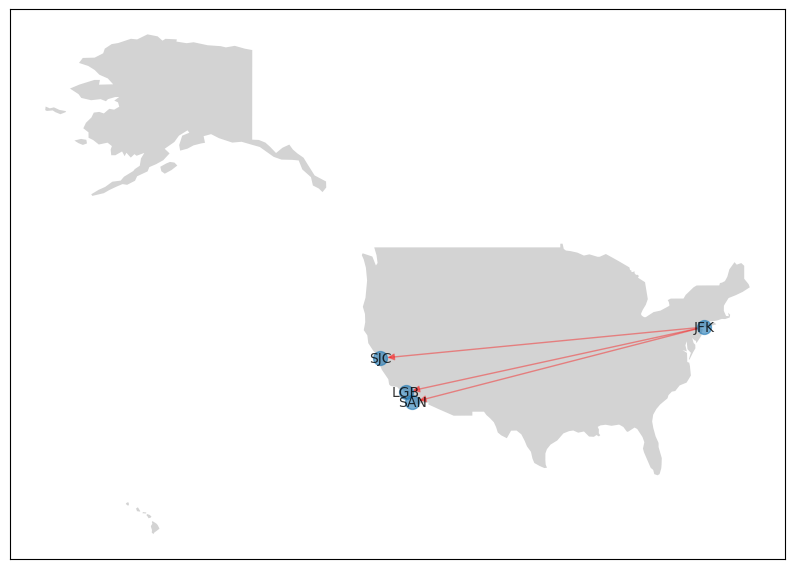

In [34]:
delay_predict(aip_out=aip_out.value,
              year=date_choose.value.year,
              month=date_choose.value.month,
              day=date_choose.value.day,
              hour=hour_choose.value,
              aip_in=aip_in.value,
              airline=airl.value,
              minute=minute_choose.value)